# 1 - Load Data & Preprocess
do some data exploration here and maybe based on that explain what we're going to do

In [2]:
from pathlib import Path
from os.path import abspath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

In [3]:
home_path = Path(abspath(''))
train_data_path = home_path.joinpath('data/train_2025.csv')
test_data_path = home_path.joinpath('data/test_2025.csv')
test_answers_path = home_path.joinpath('data/answer_key_2025.csv')

In [4]:
X_dataframe = pd.read_csv(train_data_path)
test_X_dataframe = pd.read_csv(test_data_path)
test_y_dataframe = pd.read_csv(test_answers_path)

In [5]:
X_dataframe.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000,Outcome,Id
0,4.0,107.0,135.0,15752.0,459.0,189.0,222.0,2258.0,2992.0,77.0,...,156.0,18368.0,318.0,89.0,307.0,82.0,227.0,302.0,3,3328
1,4.0,96.0,130.0,13704.0,486.0,244.0,298.0,NaN,1874.0,50.0,...,82.0,21033.0,375.0,NaN,426.0,91.0,232.0,116.0,1,2085
2,5.0,139.0,71.0,13866.0,326.0,418.0,402.0,2833.0,1821.0,64.0,...,122.0,13853.0,244.0,114.0,273.0,87.0,219.0,NaN,3,2455
3,3.0,135.0,47.0,14945.0,432.0,239.0,224.0,3020.0,2958.0,69.0,...,50.0,16328.0,289.0,NaN,NaN,98.0,244.0,312.0,3,2457
4,2.0,69.0,48.0,8758.0,337.0,214.0,358.0,NaN,3388.0,80.0,...,119.0,10714.0,557.0,99.0,206.0,107.0,136.0,364.0,1,3641



Total missing values across features: 497869
Missing values per feature (showing non-zero counts):
Gene 1       250
Gene 2       237
Gene 3       266
Gene 4       255
Gene 5       249
            ... 
Gene 1996    239
Gene 1997    253
Gene 1998    259
Gene 1999    252
Gene 2000    236
Length: 2000, dtype: int64

Total infinite values: 0
Total negative values: 0

Class counts:
Outcome
3    1280
2     881
1     730
0     629
Name: count, dtype: int64

Class proportions:
Outcome
3    0.363636
2    0.250284
1    0.207386
0    0.178693
Name: count, dtype: float64

Number of highly correlated feature pairs (r > 0.95): 59
A few example pairs (feature1, feature2, correlation):
('Gene 4', 'Gene 1323', 0.9999999926269247)
('Gene 8', 'Gene 1822', 0.9999994950756063)
('Gene 32', 'Gene 888', 0.9999999662673034)
('Gene 39', 'Gene 84', 0.9999991915915483)
('Gene 39', 'Gene 848', 0.9999996451767204)

Maximum expression value in the data: 51663.0
Minimum expression value in the data: 0.0

Feature with

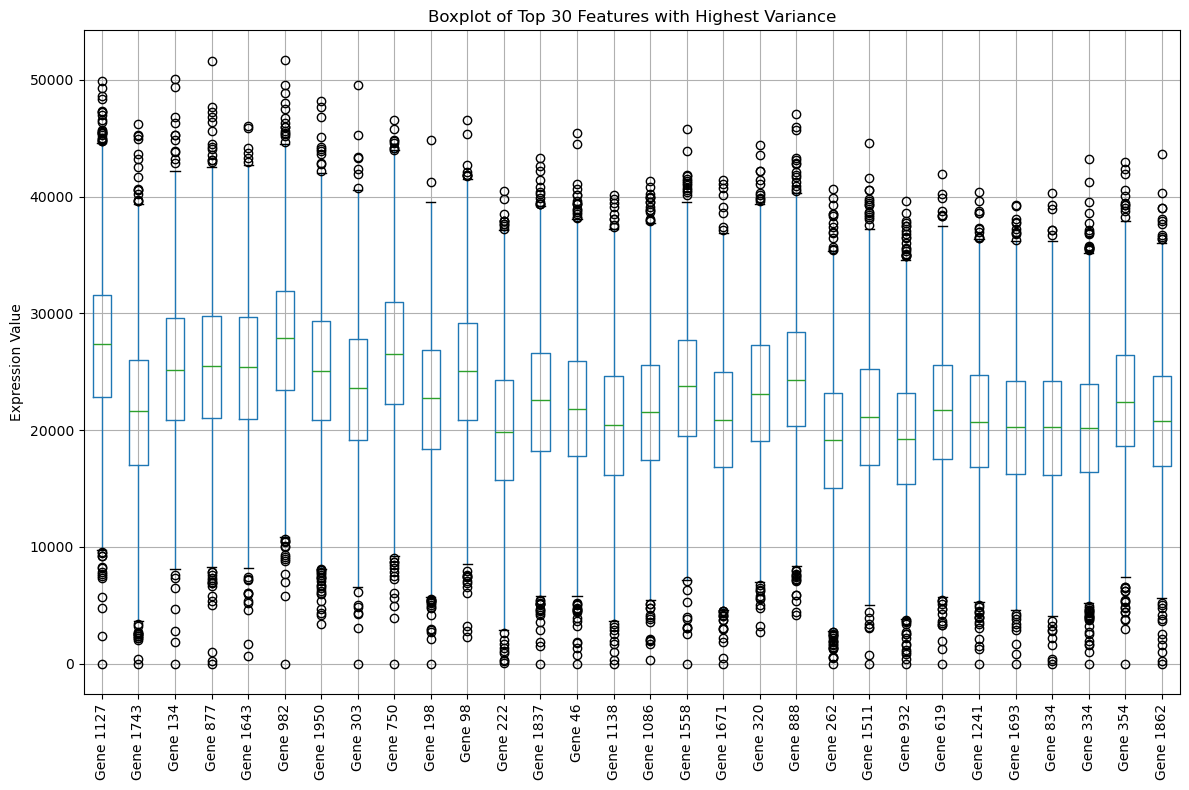

In [6]:
# --- Assume the following dataframes are already loaded:
# X_dataframe (training data with gene expression features and a label column, e.g. "label")
# test_X_dataframe and test_y_dataframe are loaded similarly

# Seperate features and target variable
target_name = 'Outcome'
labels = X_dataframe[target_name]
features = X_dataframe.drop([target_name, 'Id'], axis=1) # DROPPING ID HERE BUT MIGHT BE GOOD TO LEAVE IN

# 1. Count missing data
missing_counts = features.isna().sum()
total_missing = missing_counts.sum()
print("\nTotal missing values across features:", total_missing)
print("Missing values per feature (showing non-zero counts):")
print(missing_counts[missing_counts > 0])

# 2. Check for other strange values
# Here we check for infinite values and negative values.
num_infinite = np.isinf(features.values).sum()
num_negative = (features < 0).sum().sum()
print("\nTotal infinite values:", num_infinite)
print("Total negative values:", num_negative)
# (Depending on your data processing, gene expression data might be expected to be non-negative.)

# 3. Proportion of classes (if labels available)
if labels is not None:
    class_counts = labels.value_counts()
    print("\nClass counts:")
    print(class_counts)
    print("\nClass proportions:")
    print(class_counts / class_counts.sum())

# 4. Check for extremely high correlation between features.
# We define "extremely highly correlated" as absolute Pearson correlation > 0.95.
corr_matrix = features.corr().abs()
threshold = 0.95
high_corr_pairs = []
cols = corr_matrix.columns

# Count only unique pairs (i < j to avoid double counting)
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

print("\nNumber of highly correlated feature pairs (r > 0.95):", len(high_corr_pairs))
if len(high_corr_pairs) > 0:
    print("A few example pairs (feature1, feature2, correlation):")
    for pair in high_corr_pairs[:5]:
        print(pair)

# 5. Maximum and minimum values in the features
max_val = features.max().max()
min_val = features.min().min()
print("\nMaximum expression value in the data:", max_val)
print("Minimum expression value in the data:", min_val)

# 6. Feature with the highest variance.
variances = features.var()
top_feature = variances.idxmax()
print("\nFeature with the highest variance:", top_feature)
print("Highest variance value:", variances.max())

# Additionally, demonstrate scikit-learn's VarianceThreshold.
vt = VarianceThreshold(threshold=0)  # threshold 0 selects all non-constant features
vt.fit(features)
# vt.variances_ holds the variances for each feature (in the same order as features.columns)
print("\nFirst five variances using VarianceThreshold:", vt.variances_[:5])

# 7. Boxplot of the top 30 features with highest variance.
# Identify top 30 features ordered by variance
top30_features = variances.sort_values(ascending=False).head(30).index
plt.figure(figsize=(12, 8))
# Boxplot for each selected feature
features[top30_features].boxplot(rot=90)
plt.title("Boxplot of Top 30 Features with Highest Variance")
plt.ylabel("Expression Value")
plt.tight_layout()
plt.show()


## HOW TO IMPROVE DATA EXPLORE
- have all this in formation in the graphs

# 2 - Downsample data

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Assume X is your features and y is your labels
rus = RandomUnderSampler(random_state=42)
X_downSampled, y_downSampled = rus.fit_resample(features, labels)

# Checking:
class_counts = y_downSampled.value_counts()
print("\nClass counts:")
print(class_counts)

c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Class counts:
Outcome
0    629
1    629
2    629
3    629
Name: count, dtype: int64


In [8]:
# Showing the head and tail of balanced downsampled data
display(X_downSampled.head(5))
display(X_downSampled.tail(5))
display(y_downSampled.head(5))
display(y_downSampled.tail(5))

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1991,Gene 1992,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000
7,NaN,93.0,116.0,17932.0,409.0,249.0,278.0,2953.0,2021.0,69.0,...,7210.0,17690.0,86.0,14963.0,445.0,160.0,214.0,115.0,217.0,198.0
11,4.0,99.0,84.0,15956.0,452.0,296.0,407.0,3167.0,2169.0,39.0,...,3880.0,17901.0,123.0,17115.0,286.0,150.0,237.0,NaN,NaN,137.0
12,5.0,118.0,120.0,20132.0,538.0,405.0,290.0,2813.0,1739.0,34.0,...,NaN,20810.0,111.0,15853.0,391.0,105.0,290.0,67.0,259.0,302.0
15,5.0,79.0,82.0,11633.0,608.0,231.0,519.0,1756.0,1209.0,49.0,...,6561.0,21187.0,162.0,15585.0,439.0,94.0,259.0,124.0,115.0,163.0
17,5.0,125.0,54.0,NaN,313.0,276.0,369.0,2088.0,2759.0,54.0,...,11090.0,33076.0,99.0,14565.0,358.0,128.0,270.0,77.0,168.0,186.0


,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1991,Gene 1992,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000
2995,4.0,114.0,80.0,12000.0,NaN,435.0,398.0,2059.0,1345.0,89.0,...,11219.0,26282.0,139.0,NaN,396.0,128.0,254.0,67.0,NaN,271.0
2601,4.0,81.0,114.0,16504.0,298.0,243.0,536.0,2378.0,2293.0,48.0,...,9584.0,18903.0,96.0,15749.0,385.0,170.0,230.0,63.0,212.0,159.0
1310,5.0,101.0,55.0,16208.0,448.0,281.0,509.0,1169.0,2987.0,50.0,...,6066.0,17372.0,129.0,18914.0,352.0,110.0,385.0,73.0,153.0,254.0
2816,3.0,110.0,113.0,15376.0,310.0,253.0,306.0,2865.0,2861.0,64.0,...,9424.0,21083.0,84.0,19860.0,329.0,236.0,208.0,63.0,NaN,108.0
1372,4.0,152.0,96.0,14202.0,166.0,258.0,326.0,2222.0,1918.0,77.0,...,6554.0,23031.0,120.0,20175.0,535.0,109.0,394.0,73.0,180.0,239.0


7     0
11    0
12    0
15    0
17    0
Name: Outcome, dtype: int64

2995    3
2601    3
1310    3
2816    3
1372    3
Name: Outcome, dtype: int64

# Initialize experiments
Initialize model, pipeline, cross validation, and run them

## 3, 4, 5 - Regression

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import cross_validate

In [45]:
global_seed = 42

### 3 - Simple imputation, Standard Scaling, and non-regularized Logistic regression

Make a Pipeline that combines three steps: 
* imputing missing data (removing np.nan) by replacing them with the mean value (SimpleImputer) ✅
* scaling the data to have 0 mean and unit variance (StandardScaler) ✅
* predicting the class using unregularized logistic regression (sklearn.linear_model.LogisticRegression) ✅

Now
* split the training data into 20% validation and 80% train data. ✅
* Fit the Pipeline on the train data and test on the validation data. ✅

In your notebook file:
* report the ROC AUC one-versus-rest and macro F1 score on the training and validation data. ✅
* Read up on these here (1, 2) so you know what they are, and write what they do in your own words in the notebook. ✅
* describe why you can’t directly impute and/or scale on all the training data and only then split into train and validation sets if you want an accurate estimate of your generalisation performance ✅

In [ ]:
# Split the data into train and validation datasets (both data and labels)
train_data_3, val_data_3, train_lables_3, val_lables_3 = train_test_split(X_downSampled, y_downSampled, train_size=0.8, random_state=global_seed)

# Build the pipeline for our model
imputer_3 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_3 = StandardScaler()
log_regressor_3 = LogisticRegression(penalty=None)

model_3 = make_pipeline(imputer_3, scaler_3, log_regressor_3)

# train model
start = time.time()
model_3.fit(train_data_3, train_lables_3)
print(f"Fitting took {time.time() - start:0.03} seconds")

# validate model - get the accuracy on the validation dataset
accuracy_3 = model_3.score(val_data_3, val_lables_3)
print(f"Accuracy of model on validation dataset: {accuracy_3:0.03}")

Fitting took 0.505 seconds
Accuracy of model on validation dataset: 0.631


**The reason we can't can’t directly impute and/or scale on all the training data and only then split into train and validation sets if we want an accurate estimate of your generalisation performance**

If we first impute and/or scale our data and only then split it into training and validation, we are introducing into our model some information about the validation data which is supposed to be unseen data. This data leakage would influence the pipeline and lead to more optimistic results on the validation dataset, but we wouldn't be able to know how our model generalizes on truly unseen data.

In [ ]:
# Reporting the Macro F1 and the ROC AUC OvR scores for our trained model

# Training
# We use the predict_proba and not predict, since for ROC (and AUC) we need to predict for different thresholds
train_3_OvR_AUC = roc_auc_score(train_lables_3, model_3.predict_proba(train_data_3), multi_class='ovr')
train_3_macro_F1 = f1_score(train_lables_3, model_3.predict(train_data_3), average='macro')
print(f"Our model's scores on the training dataset:")
print(f"OvR AUC score: {train_3_OvR_AUC:0.03}\nMacro F1 score: {train_3_macro_F1:0.03}\n")

# Validation
val_3_OvR_AUC = roc_auc_score(val_lables_3, model_3.predict_proba(val_data_3), multi_class='ovr')
val_3_macro_F1 = f1_score(val_lables_3, model_3.predict(val_data_3), average='macro')
print(f"Our model's scores on the validation dataset:")
print(f"OvR AUC score: {val_3_OvR_AUC:0.03}\nMacro F1 score: {val_3_macro_F1:0.03}\n")

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Our model's scores on the validation dataset:
OvR AUC score: 0.866
Macro F1 score: 0.63



**What are ROC AUC one-versus-rest and macro F1 score?**

_ROC AUC one-versus-rest (OvR):_

OvR is A method to used binary-class-metrics to evaluate multiclass models. In this method, we iterate on our classification output n times, each time taking the n-th class as "Positive" and all other classes as "Negative". This enable us to treat each of these iterations as a binary classification. We then get the results of all metrics on each of these iterations, and average them to get the final OvR model scores.

For ROC AUC one-versus-rest we plot an ROC curve and calculate the AUC for every iteration of OvR, and return the final average score of AUC.

_macro F1 score:_

F1 is a metric that combines both precision and recall. For multi-class classification, we calculate F1 score using OvR. To combine the scores into one final score, there are different methods, one of which is Macro Average.

With Macro Average, we take the unweighted mean of the F1 scores per class (OvR). This gives a similar weight to all classes, even for an imbalanced data.

### 4 - KNN imputation, Standard Scaling, and non-regularized Logistic regression

Again, make a Pipeline that combines three steps:
* scaling each value to 0 mean and unit variance ✅
* using a KNN imputer to impute missing data (removing np.nan). Set n_neighbors to 3 and weights to ‘distance’. Make sure you understand what this does. ✅
* Using a logistic regression without regularisation to predict the class. ✅
* Train on the same 80% split ✅
* report the performance on the validation data (F1 macro; ROC AUC OvR). ✅
* Then finally train on all your training data, and predict on the test set. ❌❌❌❌ (**Dieter removed this**)
* In your notebook, write down why the order of imputation and scaling is now different compared to step 3, and what would happen if you do it the other way around. ✅


In [ ]:
# Build the pipeline for our model
imputer_4 = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')
scaler_4 = StandardScaler()
log_regressor_4 = LogisticRegression(penalty=None)

model_4 = make_pipeline(scaler_4, imputer_4, log_regressor_4)

# train model
start = time.time()
model_4.fit(train_data_3, train_lables_3)
print(f"Fitting took {time.time() - start:0.03} seconds")

# validate model - get the accuracy on the validation dataset
accuracy_4 = model_4.score(val_data_3, val_lables_3)
print(f"Accuracy of model on validation dataset: {accuracy_4:0.03}")

Fitting took 1.93e+02 seconds
Accuracy of model on validation dataset: 0.643


We can see that using KNN imputation takes a lot longer than the simple impute (193 seconds vs. 0.505 seconds).

In [ ]:
# Reporting the Macro F1 and the ROC AUC OvR scores for our trained model

# Training
start = time.time()
# We use the predict_proba and not predict, since for ROC (and AUC) we need to predict for different thresholds
train_4_OvR_AUC = roc_auc_score(train_lables_3, model_4.predict_proba(train_data_3), multi_class='ovr')
train_4_macro_F1 = f1_score(train_lables_3, model_4.predict(train_data_3), average='macro')
print(f"Our model's scores on the training dataset:")
print(f"OvR AUC score: {train_4_OvR_AUC:0.03}\nMacro F1 score: {train_4_macro_F1:0.03}")
print(f"Getting score took {time.time() - start:0.03} seconds\n")

# Validation
start = time.time()
val_4_OvR_AUC = roc_auc_score(val_lables_3, model_4.predict_proba(val_data_3), multi_class='ovr')
val_4_macro_F1 = f1_score(val_lables_3, model_4.predict(val_data_3), average='macro')
print(f"Our model's scores on the validation dataset:")
print(f"OvR AUC score: {val_4_OvR_AUC:0.03}\nMacro F1 score: {val_4_macro_F1:0.03}\n")
print(f"Getting score took {time.time() - start:0.03} seconds")

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Getting score took 3.23e+02 seconds
Our model's scores on the validation dataset:
OvR AUC score: 0.877
Macro F1 score: 0.642

Getting score took 71.8 seconds


**Why the order of imputation and scaling is now different compared to step 3, and what would happen if we do it the other way around?**

The simple imputer we used in model 3 only uses the mean to impute the missing values.

In contrast, with KNN imputation we search of the n most similar rows to the row with the missing value. Then, it calculate the average (if weight='distance' then this is a weighted average where the weights are the inverse of the distance from our row to this neighbor), and assigns this as the missing value.

If the data is not scaled, then features with a larger range of values would have less effect on the neighbors chosen for KNN imputation than features with a smaller range. Less effect because we use weight that are the inverse of the distance, and a larger range of values would then on average give smaller weights.Therefore it's important to first scale the data.

If we first impute using KNN and only then scale, then some features will dominante over other in the imputation.

**Extra - comparing model with different imputations**

Model 3 scores on the validation dataset:
* OvR AUC score: 0.866
* Macro F1 score: 0.63

Model 4 scores on the validation dataset:
* OvR AUC score: 0.877
* Macro F1 score: 0.642

We can see that the model with KNN imputation performs slightly better than the one with the simple imputation. This makes sense, since KNN can take into account correlation between features and can learn from the structure of the data, and thus create a more realistic imputation.

However, KNN imputation does take a longer time hence we'll still be using the simple imputation.

### 5 - Simple imputation, and L2 regularized Logistic regression - with cross validation

Regularise using an L2 penalty with a C of one. Note that C is 1/λ. ✅

We will also use cross-validation now, as we know that this gives a better estimate of generalisation performance and uses training data more efficiently.

Make a new Pipeline that:
* uses the SimpleImputer again (KNN is slow) ✅
* uses L2-regularised logistic regression for classification ✅

For training the model:
* use 10-fold cross-validation rather than a single split. Use sklearn.model_selection.cross_validate ✅
* look at F1 macro and ROC AUC OvR averaged over the folds. ✅

Finally
* Report how much average cross-validation performance with regularisation included improves over unregularized logistic regression. ✅

In [ ]:
# Build the pipeline for our model
imputer_5 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_5 = StandardScaler()
log_regressor_5 = LogisticRegression(penalty='l2', C=1)

model_5 = make_pipeline(imputer_5, scaler_5, log_regressor_5)

# train model
start = time.time()
cv_result_5 = cross_validate(model_5, X_downSampled, y_downSampled, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])
print(f"Fitting took {time.time() - start:0.03} seconds")

Fitting took 12.8 seconds


In [ ]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_5['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_5['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_5['test_roc_auc_ovr']):0.03}")

Average accuracy of model across folds: 0.652
Average Macro F1 score of model across folds: 0.652
Average OvR AUC score of model across folds: 0.875


**Reporting how much average cross-validation performance with regularisation included improves over unregularized logistic regression**

When performing unregularized logistic regression without cross-validation (model 3) we got the following scores on the validation dataset:
* Accuracy: 0.631
* Macro F1: 0.63
* OvR AUC: 0.866

In comparsion, we can see that all scores improve when performing a cross validation with a regularized logistic regression and taking the average scores on all folds.

We can see that both accuracy and Macro F1 improved by ~13%, and OvR AUC improved by ~5% (using percent increase, calculations below).

In [121]:
accuracy_change = ((0.713-0.631)/0.631) * 100
macro_F1_change = ((0.713-0.63)/0.63) * 100
OvR_AUC_change = ((0.908-0.866)/0.866) * 100

print(f"accuracy_change: {accuracy_change:.2f}%\nmacro_F1_change: {macro_F1_change:.2f}%\nOvR_AUC_change: {OvR_AUC_change:.2f}%")

accuracy_change: 13.00%
macro_F1_change: 13.17%
OvR_AUC_change: 4.85%


## 6, 7, 8 - PCA

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [10]:
global_seed = 42

### 6 - PCA

* Do a PCA on your (normalised, imputed) training data (all of it, not within a Pipeline) ✅
* make a plot of the first 2 PCs. ✅
  * Colour the points by the class labels. ✅
* How much variance is on the first and second component? ✅
* Which single feature contributes the most to each PC? ✅


I want to see this plot and the answer to these two questions in your notebook ✅

In [ ]:
# Preprocess data
imputer_scaler = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), 
                               StandardScaler())
imputer_scaler.fit(X_downSampled)
X_downSampled_scaled = imputer_scaler.transform(X_downSampled)

# Get PCs
pca = PCA()
X_pca = pca.fit_transform(X_downSampled_scaled)

C:\Users\samar\AppData\Local\Temp\ipykernel_88892\3902970740.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


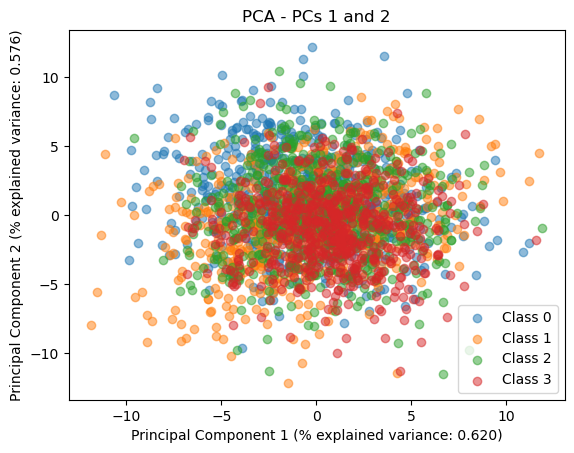

In [156]:
# Create PCA plot
fig, ax = plt.subplots()
plt.title('PCA - PCs 1 and 2')
plt.xlabel(f'Principal Component 1 (% explained variance: {pca.explained_variance_ratio_[0]*100:.3f})')
plt.ylabel(f'Principal Component 2 (% explained variance: {pca.explained_variance_ratio_[1]*100:.3f})')

for class_id in y_downSampled.unique():
    ix = np.where(y_downSampled == class_id)
    ax.scatter(x=X_pca[ix, 0], y=X_pca[ix, 1], label="Class "+str(class_id), alpha=0.5)

ax.legend()
fig.show()

**How much variance is on the first and second component?**

In [71]:
print(f"Variance explained by first 2 PCs: {sum(pca.explained_variance_ratio_[:2])*100:.3f}%")

Variance explained by first 2 PCs: 1.196%


**Which single feature contributes the most to each PC?**


In [ ]:
pca_components = np.abs(pca.components_)

pca_feature_per_pc_df = pd.DataFrame(
    {"PC": [f"PC {i+1}" for i in range(pca_components.shape[0])], 
     "Most contributing feature": [X_downSampled.columns[i] for i in np.argmax(pca_components, axis=1)]}
)

pca_feature_per_pc_df  = pca_feature_per_pc_df.set_index("PC")

print("Showing which feature (gene) contributes the most to each of the PCs")
display(pca_feature_per_pc_df)

Showing which feature (gene) contributes the most to each of the PCs


,Most contributing feature
PC,
PC 1,Gene 618
PC 2,Gene 1521
PC 3,Gene 1564
PC 4,Gene 1920
PC 5,Gene 1806
...,...
PC 1996,Gene 1510
PC 1997,Gene 1693
PC 1998,Gene 506


**Extra - plotting the explained variance in % for all PCs**

C:\Users\samar\AppData\Local\Temp\ipykernel_88892\3065823272.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


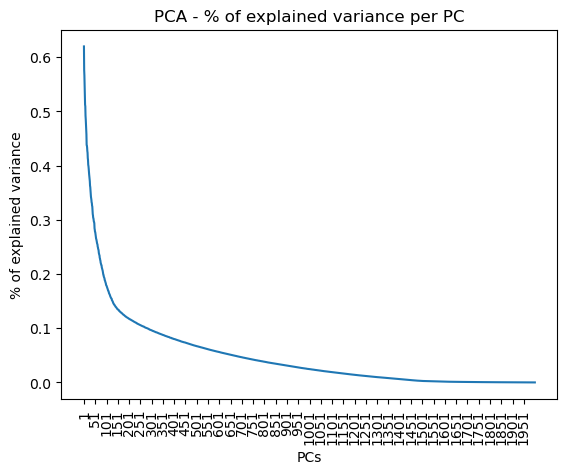

In [48]:
# Plot all explained variances per PC
explained_variance = pca.explained_variance_ratio_ * 100

fig, ax = plt.subplots()
plt.title(r'PCA - % of explained variance per PC')
plt.xlabel('PCs')
plt.ylabel(r'% of explained variance')

ax.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xticks(range(1, len(explained_variance) + 1, 50), rotation=90)

fig.show()

**Extra - find variance captured in more PCs**

In [65]:
print(f"Variance explained by first 100 PCs: {sum(pca.explained_variance_ratio_[:100])*100:.3f}%")

Variance explained by first 100 PCs: 30.834%


In [100]:
print(r"To capture 70% of the variance we need to take", np.where(pca.explained_variance_ratio_.cumsum() > 0.7)[0][0], "PCs")
print(r"To capture 80% of the variance we need to take", np.where(pca.explained_variance_ratio_.cumsum() > 0.8)[0][0], "PCs")
print(r"To capture 90% of the variance we need to take", np.where(pca.explained_variance_ratio_.cumsum() > 0.9)[0][0], "PCs")

print('\n** "To capture" meaning to capture at least this amount of variance')

To capture 70% of the variance we need to take 477 PCs
To capture 80% of the variance we need to take 642 PCs
To capture 90% of the variance we need to take 883 PCs

** "To capture" meaning to capture at least this amount of variance


**Extra - discussing the PCA results**

We can see that there is no small amount of features that capture a big precent of the variance. To capture at least 70% of the variance we need to take 477 PCs, 642 PCs for 80% of the variance and 883 PCs for 90% of the variance.

In part 7 we use 100 PCs in our model. We see that although this improve the performance of the model, the improvement is not great. This might be due to the fact that these 100 PCs only capture ~30% of the data, and hence this might not be enough to train our model.

### 7 - PCA inside a prediction pipeline

For the next part, let’s 
* use PCA in your prediction Pipeline. ✅
  * Insert a PCA step where you think it fits ✅
    * use 100 principal components. ✅
* Keep the regularisation in your logistic regression. ✅
* Report the average macro F1 score and ROC AUC OvR over folds now that you’ve included linear dimensionality reduction in your notebook. ✅
* How many percentage points do you improve? ✅
* Train a final model on all training data. Use this final model to predict on the test set. ❌❌❌❌ (**Dieter removed this**)

In [ ]:
# Build the pipeline for our model
imputer_7 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_7 = StandardScaler()
pca_7 = PCA(n_components=100)
log_regressor_7 = LogisticRegression(penalty='l2', C=1)

model_7 = make_pipeline(imputer_7, scaler_7, pca_7, log_regressor_7)

# train model
start = time.time()
cv_result_7 = cross_validate(model_7, X_downSampled, y_downSampled, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])
print(f"Fitting took {time.time() - start:0.03} seconds")

Fitting took 9.84 seconds


In [ ]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_7['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_7['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_7['test_roc_auc_ovr']):0.03}")

Average accuracy of model across folds: 0.68
Average Macro F1 score of model across folds: 0.68
Average OvR AUC score of model across folds: 0.886


**How many percentage points do you improve?**
(Comparing to model 5)

When adding PCA and taking the 100 PCs that explain the most variance, we can see that the model improves a bit. We see an improvement of ~3 percent points in accuracy and Macro F1 score, and an improvement of ~1 percent points in OvR AUC score.
(calculations below)

Although this is an improvement, this is not a big improvement. We saw in part 6 that these 100 PCs only capture ~30% of the variance in our data, which might be the reason why the model doesn't perform as well as we've hoped. Still, this small improvement suggests that we hopefully managed to reduce the noise in our data and helped our model generalize better.

In [165]:
# Compare the scored for model 5 (no PCA) and model 7 (includes PCA with choosing 
# 100 principal components)
accuracy_change = (np.mean(cv_result_7['test_accuracy'])-np.mean(cv_result_5['test_accuracy'])) * 100
macro_F1_change = (np.mean(cv_result_7['test_f1_macro'])-np.mean(cv_result_5['test_f1_macro'])) * 100
OvR_AUC_change = (np.mean(cv_result_7['test_roc_auc_ovr'])-np.mean(cv_result_5['test_roc_auc_ovr'])) * 100

print(f"accuracy_change: {accuracy_change:.2f} percent points\nmacro_F1_change: {macro_F1_change:.2f} percent points\nOvR_AUC_change: {OvR_AUC_change:.2f} percent points")

accuracy_change: 2.78 percent points
macro_F1_change: 2.80 percent points
OvR_AUC_change: 1.10 percent points


In [157]:
# Training a final model (model 7)
final_model_7 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    PCA(n_components=100), 
    LogisticRegression(penalty='l2', C=1)
)

final_model_7.fit(X=X_downSampled, y=y_downSampled)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=100)),
                ('logisticregression', LogisticRegression(C=1))])

### 8 - PCA with nested cross-validation

There’s two things left to do: 
1. using nested cross-validation for hyperparameter optimalisation
2. training some different classifiers. 

Let’s focus on nested cross-validation first.
* do a RandomizedSearchCV over n_components for the PCA [50, 100, 200, 500] and C for the logistic regression [0.01, 0.1, 1, 10, 100]. ✅
* Use an outer_cv of 5, and an inner_cv of 3. ✅
* In your notebook, again report the average F1 macro and ROC AUC OvR over outer folds. ✅

Finally,
* train a classifier on all the train data using the best hyperparameters (take the average of the ones used in the outer folds), and ✅
* make your predictions on the test set. ❌

In [ ]:
# Define values for the nested cross-validation and hyperparameters tuning
pca_vals = [50, 100, 200, 500]
c_vals = [0.01, 0.1, 1, 10, 100]
outer_cv = 5
inner_cv = 3

grid = {"pca__n_components": pca_vals, "logisticregression__C": c_vals}

# Build the pipeline for our model
imputer_8 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_8 = StandardScaler()
pca_8 = PCA()
log_regressor_8 = LogisticRegression(penalty='l2')

model_8 = make_pipeline(imputer_8, scaler_8, pca_8, log_regressor_8)

# train model - perform nested cross validation with random search for hyperparameter tuning
cv_search = RandomizedSearchCV(estimator=model_8, cv=inner_cv, param_distributions=grid,
                               refit=True, n_jobs=-1, n_iter=20)

cv_result_8 = cross_validate(cv_search, X=X_downSampled, y=y_downSampled, cv=outer_cv,
                             scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'],
                             return_estimator=True)

In [ ]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_8['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_8['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_8['test_roc_auc_ovr']):0.03}")

Average accuracy of model across folds: 0.678
Average Macro F1 score of model across folds: 0.678
Average OvR AUC score of model across folds: 0.895


In [ ]:
# Viewing best performing parameters for each of the our folds
for outer_i in range(outer_cv):
    print(f"# Best parameters for fold {outer_i}:")
    print(cv_result_8['estimator'][outer_i].best_params_)

# Best parameters for fold 0:
{'pca__n_components': 200, 'logisticregression__C': 0.01}
# Best parameters for fold 1:
{'pca__n_components': 200, 'logisticregression__C': 0.01}
# Best parameters for fold 2:
{'pca__n_components': 500, 'logisticregression__C': 0.01}
# Best parameters for fold 3:
{'pca__n_components': 500, 'logisticregression__C': 0.01}
# Best parameters for fold 4:
{'pca__n_components': 100, 'logisticregression__C': 0.1}


In [ ]:
# Get hyperparameters for final model (model 8)
# These are the best perfoeming parameters for each of the inner folds
# Taking the average of the parameters used in the outer folds as instructed, but then 
# rounding the value of n_components since it should be of type int.
n_components = np.round(np.mean([cv_result_8['estimator'][outer_i].best_params_['pca__n_components'] for outer_i in range(outer_cv)])).astype(np.int64)
c = np.mean([cv_result_8['estimator'][outer_i].best_params_['logisticregression__C'] for outer_i in range(outer_cv)])

# Training a final model (for model 8)
final_model_8 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    PCA(n_components=int(n_components)), 
    LogisticRegression(penalty='l2', C=c)
)

final_model_8.fit(X=X_downSampled, y=y_downSampled)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=300)),
                ('logisticregression',
                 LogisticRegression(C=0.028000000000000004))])

#### **Extra** (model 8_2)

**further optimizing hyper-parameters and using KNN imputation**

As seen before, the KNN imputation has slightly better results than the simple imputation. We will then try to use the KNN imputer, trying to optimize the number of neighbors used using nested cross validation.

In addition to that, we would also further optimize the number of components in PCA and the C value in the linear regression. We would test with best performing parameters** as found in model 8, as well as one additional parameter that is between the 2 best parameters from model 8.

**To cut back on time and computational power, we would only keep best performing parameters based on model 8 and not all possible parameters.

In [ ]:
# Define values for the nested cross-validation and hyperparameters tuning
pca_vals_8_2 = [200, 350, 500] # added 350
c_vals_8_2 = [0.01, 0.05, 0.1] # added 0.05
n_neighbors = [1, 3, 5]
outer_cv = 5
inner_cv = 3

grid = {"pca__n_components": pca_vals_8_2, "logisticregression__C": c_vals_8_2,
        "knnimputer__n_neighbors": n_neighbors}

# Build the pipeline for our model
imputer_8_2 = KNNImputer(missing_values=np.nan, weights='distance')
scaler_8_2 = StandardScaler()
pca_8_2 = PCA()
log_regressor_8_2 = LogisticRegression(penalty='l2')

model_8_2 = make_pipeline(imputer_8_2, scaler_8_2, pca_8_2, log_regressor_8_2)

# train model - perform nested cross validation with random search for hyperparameter tuning
cv_search_8_2 = RandomizedSearchCV(estimator=model_8_2, cv=inner_cv, param_distributions=grid,
                               refit=True, n_jobs=-1, n_iter=20)

cv_result_8_2 = cross_validate(cv_search_8_2, X=X_downSampled, y=y_downSampled, cv=outer_cv,
                             scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'],
                             return_estimator=True)

In [162]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_8_2['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_8_2['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_8_2['test_roc_auc_ovr']):0.03}")

# Viewing best performing parameters for each of the our folds
for outer_i in range(outer_cv):
    print(f"# Best parameters for fold {outer_i}:")
    print(cv_result_8_2['estimator'][outer_i].best_params_)

Average accuracy of model across folds: 0.7
Average Macro F1 score of model across folds: 0.7
Average OvR AUC score of model across folds: 0.903
# Best parameters for fold 0:
{'pca__n_components': 500, 'logisticregression__C': 0.01, 'knnimputer__n_neighbors': 5}
# Best parameters for fold 1:
{'pca__n_components': 200, 'logisticregression__C': 0.05, 'knnimputer__n_neighbors': 1}
# Best parameters for fold 2:
{'pca__n_components': 200, 'logisticregression__C': 0.01, 'knnimputer__n_neighbors': 1}
# Best parameters for fold 3:
{'pca__n_components': 500, 'logisticregression__C': 0.01, 'knnimputer__n_neighbors': 3}
# Best parameters for fold 4:
{'pca__n_components': 200, 'logisticregression__C': 0.01, 'knnimputer__n_neighbors': 3}


In [164]:
# Compare the scored for model 8 and model 8_2
accuracy_change = (np.mean(cv_result_8_2['test_accuracy'])-np.mean(cv_result_8['test_accuracy'])) * 100
macro_F1_change = (np.mean(cv_result_8_2['test_f1_macro'])-np.mean(cv_result_8['test_f1_macro'])) * 100
OvR_AUC_change = (np.mean(cv_result_8_2['test_roc_auc_ovr'])-np.mean(cv_result_8['test_roc_auc_ovr'])) * 100

print(f"accuracy_change: {accuracy_change:.2f} percent points\nmacro_F1_change: {macro_F1_change:.2f} percent points\nOvR_AUC_change: {OvR_AUC_change:.2f} percent points")

accuracy_change: 2.07 percent points
macro_F1_change: 2.06 percent points
OvR_AUC_change: 0.93 percent points


We can see that we indeed improve the model, however it takes a very long time to run (~80 minutes!!)

In [ ]:
# Get hyperparameters for final model (model 8_2)
# taking the average of the parameters used in the outer folds
# These are the best perfoeming parameters for each of the inner folds
n_components_8_2 = np.round(np.mean([cv_result_8_2['estimator'][outer_i].best_params_['pca__n_components'] for outer_i in range(outer_cv)])).astype(np.int64)
c_8_2 = np.mean([cv_result_8_2['estimator'][outer_i].best_params_['logisticregression__C'] for outer_i in range(outer_cv)])
n_neighbors_8_2 = np.round(np.mean([cv_result_8_2['estimator'][outer_i].best_params_['knnimputer__n_neighbors'] for outer_i in range(outer_cv)])).astype(np.int64)

# Training a final model (for model 8_2)
final_model_8_2 = make_pipeline(
    KNNImputer(missing_values=np.nan, weights='distance', n_neighbors=n_neighbors_8_2), 
    StandardScaler(), 
    PCA(n_components=int(n_components)), 
    LogisticRegression(penalty='l2', C=c)
)

final_model_8_2.fit(X=X_downSampled, y=y_downSampled)

NameError: name 'np' is not defined

# Results
analyze results

2. Disregard any instructions to test on the final, held-out test set, except until the very end where you do this for the classifiers trained in question 3, 5, 7, 9 and your own final classifier. My apologies that I left these instructions in in the wrong places. ❌ 

need TODO this

**Model 3:**

Fitting took 0.505 seconds
Accuracy of model on validation dataset: 0.631

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Our model's scores on the validation dataset:
OvR AUC score: 0.866
Macro F1 score: 0.63

**Model 4:**

Fitting took 1.93e+02 seconds
Accuracy of model on validation dataset: 0.643

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Getting score took 3.23e+02 seconds
Our model's scores on the validation dataset:
OvR AUC score: 0.877
Macro F1 score: 0.642

Getting score took 71.8 seconds

**Model 5:**

Average accuracy of model across folds: 0.713
Average Macro F1 score of model across folds: 0.713
Average OvR AUC score of model across folds: 0.908

# Ideas:

- Plot prediction against Y to get a quick high level  view of the performance
- Consider Halving gridsearch or do randomized search to decrease computation time:
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
- Plot computation time for experiment
- Quantile transform to get rid of outliers
    - Effect of transforms to get a better result. Maybe brute force it?
- plot_output(scaler=scaler) # to get a easy visualisation of what the scaler is doing